<a href="https://colab.research.google.com/github/Rupesh-Kataria/Quora-Duplicate-Question-Pair/blob/main/BERT_MODEL_CHECK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ln -s /content/gdrive/My\ Drive/ /mydrive

In [ ]:
%cd /mydrive/lstm_duplicate_question_detection

/content/gdrive/My Drive/lstm_duplicate_question_detection


In [ ]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.2 MB/s eta 0:00:00


In [ ]:
import os
import matplotlib.pyplot as plt
import copy
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from datasets import load_dataset
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from datasets import Dataset, DatasetDict
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
df = pd.read_csv("./train.csv.zip")
print(df.shape)
df.sample(10)

(404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
153041,153041,240323,240324,How do I keep away from annoying people?,How can I overcome the fear of failure especia...,0
193764,193764,293767,293768,What is wrong with assuming the speed of light...,How can Hillary Clinton counteract $50 million...,0
112188,112188,183600,183601,"In a jQuery AJAX call, what's the difference b...",Can I call jQuery methods within a function?,0
108131,108131,177733,177734,Which is the best training institute for SAP c...,Which is the best training institute for SAP i...,0
223806,223806,331718,331719,Should I join JK lakshmi cement?,Why do marketers want to know about education ...,0
215608,215608,202058,321543,How do you check the balance of an Amazon gift...,Who has an Amazon gift card they don't want wi...,0
201288,201288,303258,303259,What are some movies you regretted about for n...,What are some movies you regretted about not b...,1
131502,131502,210806,210807,Why do emergency services sirens have to be so...,Why is Americas emergency services so outdated?,1
56120,56120,98820,98821,How is aeronautical engineering important?,How is it to be an Aeronautical Engineer?,0
305788,305788,371456,429244,Where can I find sex pictures?,Where's sex?,0


In [ ]:
df.dropna(inplace=True)

In [ ]:
df.drop(['id', 'qid1', 'qid2'], axis=1, inplace=True)
df.sample(5)

,question1,question2,is_duplicate
48149,Organic Chemistry: What's the difference betwe...,How do pi and sigma bonds form?,0
82399,How is gmat preparation from EDUSHASHTRA ONLY…?,Which is the best coaching for GMAT? Is it Byj...,0
393230,What are the functional differences between ve...,What is the difference between veins and arter...,1
69561,How do I concentrate in a better way on studies?,How do I concentrate in study?,1
77442,What's the most embarrassing thing that's happ...,What are your most embarrassing stories?,1


In [ ]:
train_data, val_data = train_test_split(df, test_size=0.3, random_state=1, shuffle=False)
train_data.to_csv('train_clean.csv',index=False)
val_data.to_csv('val_clean.csv',index=False)

In [ ]:
dataset = load_dataset('csv', data_files={'train': './train_clean.csv',\
                                          'valid':'./val_clean.csv'},)
dataset

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating valid split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-4fff751ef56e80a7/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'is_duplicate'],
        num_rows: 283000
    })
    valid: Dataset({
        features: ['question1', 'question2', 'is_duplicate'],
        num_rows: 121287
    })
})

In [ ]:
model_checkpoint = "bert-base-cased"
batch_size = 32

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
tokenizer(df.question1[0], df.question2[0],
                                      padding='max_length',  # Pad to max_length
                                      truncation=True,  # Truncate to max_length
                                      max_length=100,
                                      return_tensors='tf',return_token_type_ids = True)

{'input_ids': <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[  101,  1327,  1110,  1103,  2585,  1118,  2585,  6388,  1106,
        17557,  1107,  2934,  2319,  1107,  1107,  7168,   136,   102,
         1327,  1110,  1103,  2585,  1118,  2585,  6388,  1106, 17557,
         1107,  2934,  2319,   136,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
def preprocess_function(records):
    return tokenizer(records['question1'], records['question2'], truncation=True, return_token_type_ids=True, max_length = 75)

In [ ]:
pre_tokenizer_columns = dataset["train"].features

In [ ]:
encoded_dataset = dataset.map(preprocess_function, batched=True, )

Map:   0%|          | 0/283000 [00:00<?, ? examples/s]

Map:   0%|          | 0/121287 [00:00<?, ? examples/s]

In [ ]:
tokenizer_columns = list((encoded_dataset["train"].features.keys()) - pre_tokenizer_columns)
print("Columns added by tokenizer:", tokenizer_columns)

Columns added by tokenizer: ['input_ids', 'attention_mask', 'token_type_ids']


In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf",)


tf_train_dataset = encoded_dataset["train"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["is_duplicate"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)
tf_validation_dataset = encoded_dataset["valid"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["is_duplicate"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:385: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
# sample train batch
next(iter(tf_train_dataset))

({'input_ids': <tf.Tensor: shape=(32, 58), dtype=int64, numpy=
  array([[ 101, 1327, 1110, ...,    0,    0,    0],
         [ 101, 1731, 1169, ...,    0,    0,    0],
         [ 101, 1327,  112, ...,    0,    0,    0],
         ...,
         [ 101, 1409, 1128, ...,    0,    0,    0],
         [ 101, 2181, 1175, ...,    0,    0,    0],
         [ 101, 1731, 1169, ...,    0,    0,    0]])>,
  'token_type_ids': <tf.Tensor: shape=(32, 58), dtype=int64, numpy=
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])>,
  'attention_mask': <tf.Tensor: shape=(32, 58), dtype=int64, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]])>},
 <tf.Tensor: shape=(32,), dty

In [ ]:
z=next(iter(tf_train_dataset))

In [ ]:
# sample decoded string
p=tokenizer.decode(z[0]['input_ids'][0])

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels = 2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
num_epochs = 1
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps, power = 2
)

opt = Adam(learning_rate=lr_scheduler)
loss = SparseCategoricalCrossentropy(from_logits=True)

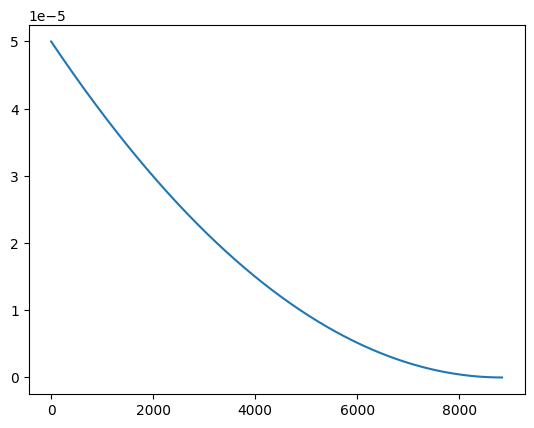

In [ ]:
lr_schedule = []
for step in range(lr_scheduler.decay_steps):

    decay = (1 - (step / float(lr_scheduler.decay_steps))) ** lr_scheduler.power
    lr_schedule.append(lr_scheduler.initial_learning_rate * decay)

plt.plot(lr_schedule)

In [ ]:
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

In [ ]:

model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=1)

8844/8844 [==============================] - 4354s 481ms/step - loss: 0.3058 - accuracy: 0.8625 - val_loss: 0.2551 - val_accuracy: 0.8893


In [ ]:
model.save_pretrained("saved_model_epoch1")

In [ ]:
trained_model = TFAutoModelForSequenceClassification.from_pretrained('saved_model_epoch1',num_labels = 2)

Some layers from the model checkpoint at saved_model_epoch1 were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at saved_model_epoch1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
def check_similarity(question1, question2, debug = 0):
  tokenizer_output = tokenizer(question1, question2, truncation=True, return_token_type_ids=True, max_length = 75, return_tensors = 'tf')
  logits = trained_model(**tokenizer_output)["logits"]
  predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
  if predicted_class_id == 1:
    if(debug):
        print("Both questions mean the same")
    return 1
  else:
    if(debug):
        print("Both the questions are different.")
    return 0

In [ ]:
q1 = 'Where is the capital of India?'
q2 = 'What is the capital of Pakistan?'
q3 = 'Which city serves as the capital of India'
q4 = 'Which city serves as the capital of Pakistan'

In [ ]:
check_similarity(q4, q3, 1)

Both the questions are different.


0

In [ ]:

def predict_result(row):

    l=[0]
    question1 = row['question1']
    question2 = row['question2']
    tokenizer_output = tokenizer(question1, question2, truncation=True, return_token_type_ids=True, max_length = 75, return_tensors = 'tf')
    logits = trained_model(**tokenizer_output)["logits"]
    predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
    if predicted_class_id == 1:
        l[0]=1
    return l

In [ ]:
new_df=df[0:2000]

In [ ]:
output= new_df.apply(predict_result, axis=1)
y_pred= list(map(lambda x: x[0], output))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
print(accuracy_score(list(new_df['is_duplicate'].values),y_pred))
confusion_matrix(list(new_df['is_duplicate'].values),y_pred)

0.924


array([[1180,   78],
       [  74,  668]])